In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import json
from typing import Dict
from tqdm import tqdm
import sys
import datetime
import seaborn as sns

In [2]:
SCALE = 10000
INPUT_FILE = '../data_{}.json'.format(SCALE)
# INPUT_FILE = '../data.json'


# with open(INPUT_FILE, 'r') as f:
#     for line in f:
#         line = line.strip()
#         r = json.loads(line)
#         print(r['login'])


In [3]:
# y,m,d
def get_create_date_from_repo(repo) -> (int, int, int):
    d = map(int, repo['created_at'].split(' ')[0].split('-'))
    d = list(d)
    return (d[0], d[1], d[2])

# y,m,d
def get_commit_date_from_commit(commit) -> (int, int, int):
    d = map(int, commit['commit_at'].split(' ')[0].split('-'))
    d = list(d)
    return (d[0], d[1], d[2])

# day of week
def get_commit_day_from_commit(commit) -> int:
    y, m, d = get_commit_date_from_commit(commit)
    h, mm, s = get_commit_time_from_commit(commit)
    date = datetime.datetime(y, m, d, h, mm, s, 0)
    # 0-6, 0 Monday, 6 Sunday
    day = date.weekday()
    return (day + 1) % 7

# h,m,s
def get_commit_time_from_commit(commit) -> (int, int, int):
    s = commit['commit_at']
    s = s.split(' ')[1]
    if '.' in s:
        d = map(int, s.split('.')[0].split(':'))
    elif '+' in s:
        d = map(int, s.split('+')[0].split(':'))
    elif '-' in s:
        d = map(int, s.split('-')[0].split(':'))
    elif s[-1] == u'Z':
        # 2000-01-01 00:00:00Z
        d = map(int, s.strip('Z').split(':'))
    else:
        assert False, 'cannot parse, ' + s

    d = list(d)
    return (d[0], d[1], d[2])
example = {'commit_at': '2000-01-01 00:00:00Z'}
get_commit_time_from_commit(example)

(0, 0, 0)

In [4]:
repos = {}
repo_list = []
num_users = 0

with tqdm(total=SCALE, file=sys.stdout) as pbar:
    with open(INPUT_FILE, 'r') as f:
        for line in f:
            pbar.update(1)
            line = line.strip()
            r = json.loads(line)
            user_id = r['id']
            # filter out suspicious user accounts
            if r['is_suspicious']: continue

            num_users += 1
            if r['repo_list'] is None: continue
            for repo in r['repo_list']:
                repo_id = repo['id']
                repos[repo_id] = repo
                repo_list.append(repo)

print('analyzing {} users'.format(num_users))
print('num repos:', len(repos))

100%|██████████| 10000/10000 [00:00<00:00, 30990.18it/s]
analyzing 7655 users
num repos: 12897


In [5]:
def update_lang_heatmap(heatmap: Dict[str, np.ndarray], commit):
    h, m, s = get_commit_time_from_commit(commit)
    repo_id = commit['repo_id']
    if repos.get(repo_id) is None: return
    lang = repos[repo_id]['language']
    heatmap.setdefault(lang, np.zeros((7, 24)))
    day = get_commit_day_from_commit(commit)
    heatmap[lang][day][h] += 1


lang_heatmap = {}
num_commits = 0

# "commit_at": "2018-05-24 20:42:37.000+08:00"

with tqdm(total=SCALE, file=sys.stdout) as pbar:
    with open(INPUT_FILE, 'r') as f:
        for line in f:
            pbar.update(1)
            line = line.strip()
            r = json.loads(line)
            user_id = r['id']
            # filter out suspicious user accounts
            if r['is_suspicious']: continue

            if r['commit_list'] is None: continue
            for c in r['commit_list']:
                num_commits += 1
                update_lang_heatmap(lang_heatmap, c)
print('number of commits:', num_commits)
print(lang_heatmap['C'])

100%|██████████| 10000/10000 [00:00<00:00, 15364.22it/s]
number of commits: 60841
[[15.  3.  2.  1.  0.  1.  0.  0.  2.  1. 12.  7.  8. 11.  9. 11.  3.  6.
   2.  2.  7.  6.  1.  2.]
 [ 4.  0.  1.  2.  0.  1.  2.  0.  3.  2.  6.  7.  5.  6.  7.  9.  5.  7.
   9.  7.  4. 12. 12.  6.]
 [ 5.  2.  3.  0.  0.  0.  0.  0.  4.  7.  4.  3.  3.  0.  3.  7.  5.  6.
  14.  8.  2.  5.  5.  5.]
 [ 1.  2.  1.  0.  0.  0.  0.  0.  1.  2.  5. 10.  3.  1.  7. 12.  5. 14.
   8.  6.  6.  3.  9.  6.]
 [ 3.  2.  0.  0.  0.  0.  1.  0.  0.  1.  2.  1.  3.  5.  1.  6.  5.  7.
   7.  3.  4.  0.  3.  1.]
 [ 4.  1.  2.  0.  2.  1.  1.  0.  1. 11.  4. 14.  5.  3.  4.  7. 14. 22.
   8.  3.  4.  4. 11.  5.]
 [ 2.  3.  2.  2.  0.  1.  0.  3.  8.  2.  1.  5.  3.  8.  7.  1.  4.  1.
   2.  4.  8.  3.  8.  4.]]


In [6]:
# test if the function works
# for repo in repos:
#     print(repo['full_name'], repo['language'], get_create_date_from_repo(repo))

In [7]:
def rank_by_values(d: Dict[str, str]) -> [(str, int)]:
    kvs = list(d.items())
    kvs.sort(key=lambda x: x[1], reverse=True)
    return kvs

all_langs = {}
for repo in repo_list:
    lang = repo['language']
    all_langs[lang] = all_langs.get(lang, 0) + 1

print('total number of different languages', len(all_langs) - 1)
all_langs = rank_by_values(all_langs)
top_langs = all_langs[10:30]
for l in top_langs:
    print(l)

total number of different languages 111
('C', 330)
('Objective-C', 237)
('Shell', 216)
('Swift', 190)
('R', 154)
('Go', 99)
('TypeScript', 97)
('Jupyter Notebook', 90)
('Lua', 53)
('Kotlin', 48)
('Scala', 46)
('TeX', 41)
('PowerShell', 32)
('Makefile', 30)
('Rust', 29)
('SaltStack', 29)
('VimL', 26)
('Matlab', 26)
('Vue', 26)
('Perl', 25)


In [10]:
from matplotlib import rcParams
# rcParams['font.family'] = 'Times New Roman'
# rcParams['font.family'] = ''
plt.rcParams["figure.figsize"] = (24, 6)
# plt.rcParams["figure.figsize"] = (0, 0)
sns.set_theme()
cmap = sns.cm.rocket_r
# cmap = sns.color_palette("rocket_r", as_cmap=False)
# cmap = sns.color_palette("mako_r", as_cmap=True)
# cmap = sns.light_palette("green", as_cmap=False)
sns.set(font_scale=2)


def unzip(d: Dict[int, int]) -> ([int], [int]):
    kvs = list(d.items())
    kvs.sort(key=lambda x: x[0])
    a, b = list(map(list, zip(*kvs)))
    return a, b

common_settings = {
    'linestyle': '--',
    # 'linewidth': 2,
    'marker': 'o',
}

def show_heatmap(heatmap: np.ndarray, no_debug=False):
    maxv = np.max(heatmap)
    heatmap = heatmap / maxv
    ax = sns.heatmap(heatmap, linewidth=5.5, square=True, cmap=cmap, cbar_kws={'label': 'Frequency'})
    ax.figure.axes[-1].yaxis.label.set_size(24)
    plt.xlabel("Hours", fontsize = 24)
    # plt.xticks(nethint0, fontsize = 20)
    plt.ylabel("Day of Week", fontsize = 24)
    #plt.ylim([0, 1])
    plt.yticks(ticks = np.arange(0, 7), labels = ['Sun  ', ' Mon  ', 'Tue  ', 'Wed  ', 'Thu  ', 'Fri  ', 'Sat  '], fontsize = 22)
    plt.xticks(fontsize = 22)
    return plt

# common_settings = { 'linestyle': '-', 'linewidth': 3, 'marker': '' }
# [(language, [(year, count)])]
def show_lang_heatmap(lang: str, no_debug=False):
    if lang not in lang_heatmap: return
    heatmap = lang_heatmap[lang]
    plt = show_heatmap(heatmap, no_debug)
    plt.title('Commits with {} in a Week'.format(lang), fontsize = 26)

    # name = "/tmp/lang_workhours_{}_2.pdf".format(lang)
    # plt.savefig(name, bbox_inches='tight')
    plt.show()

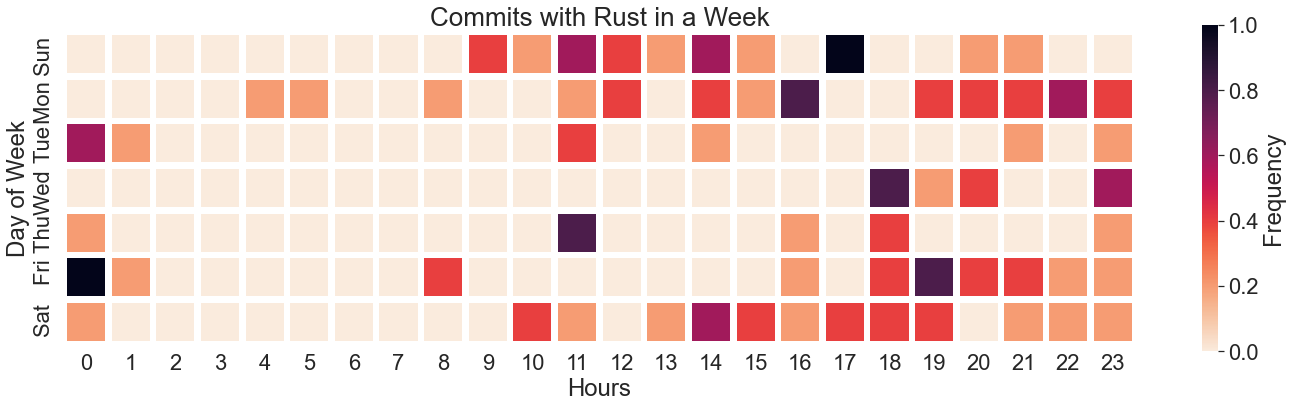

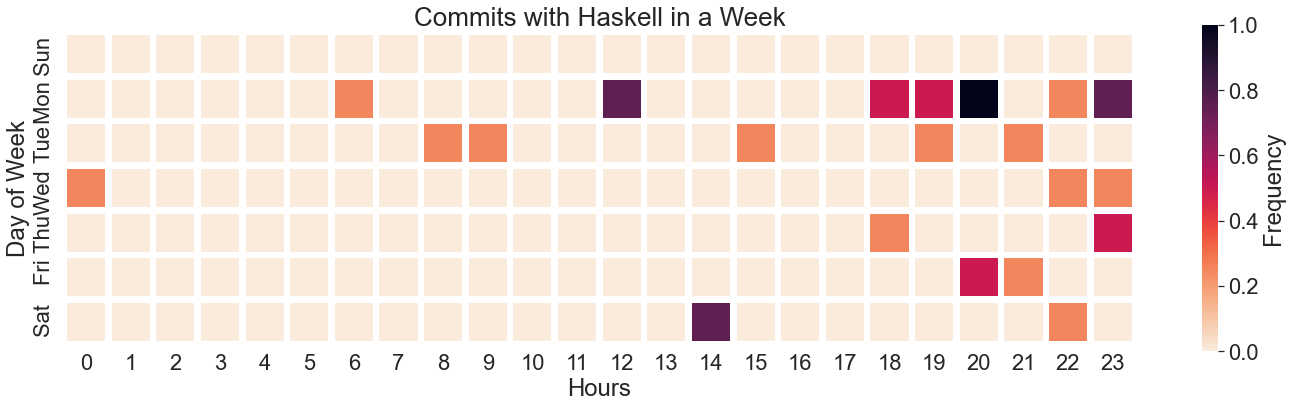

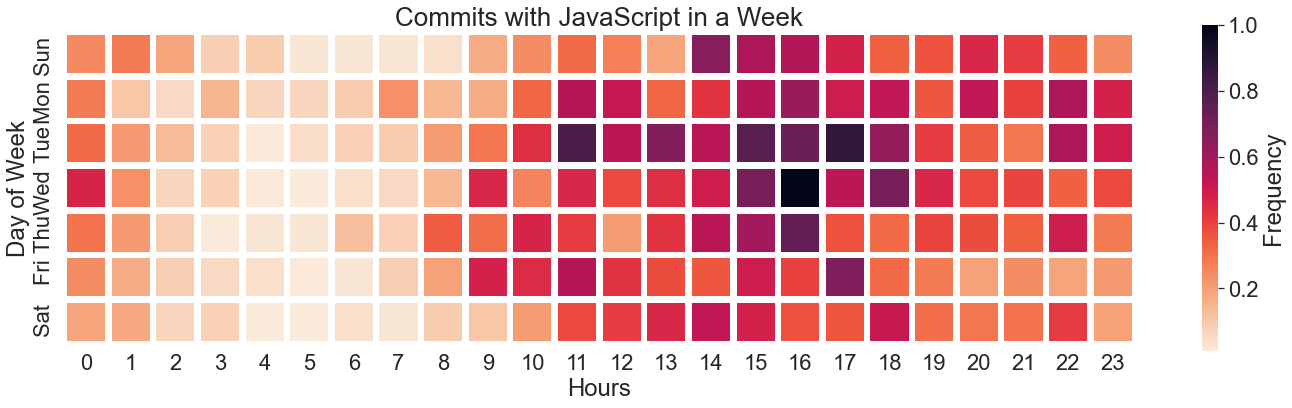

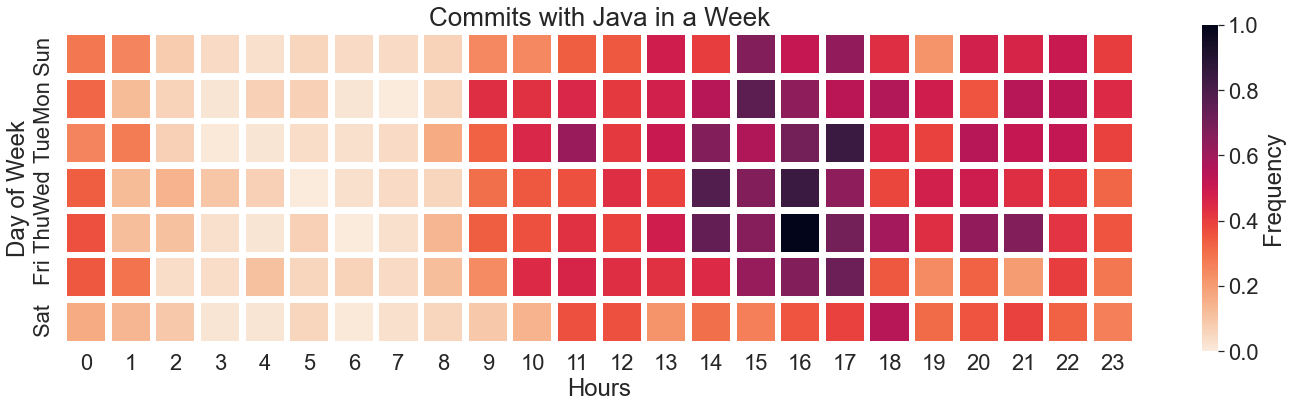

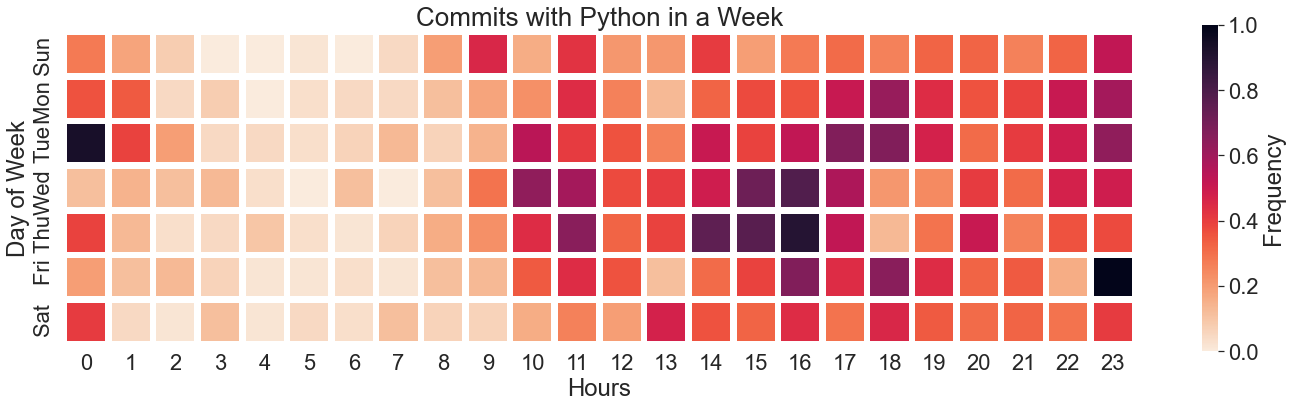

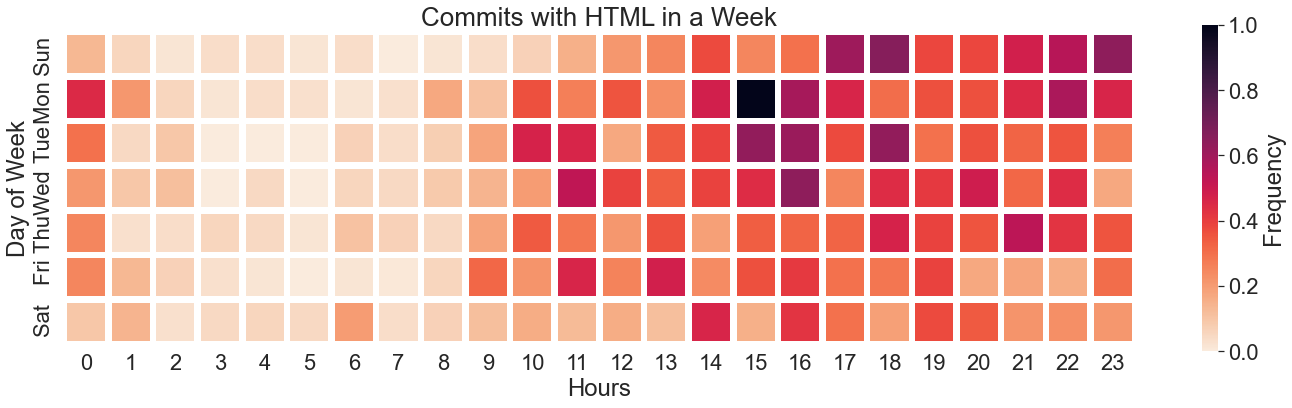

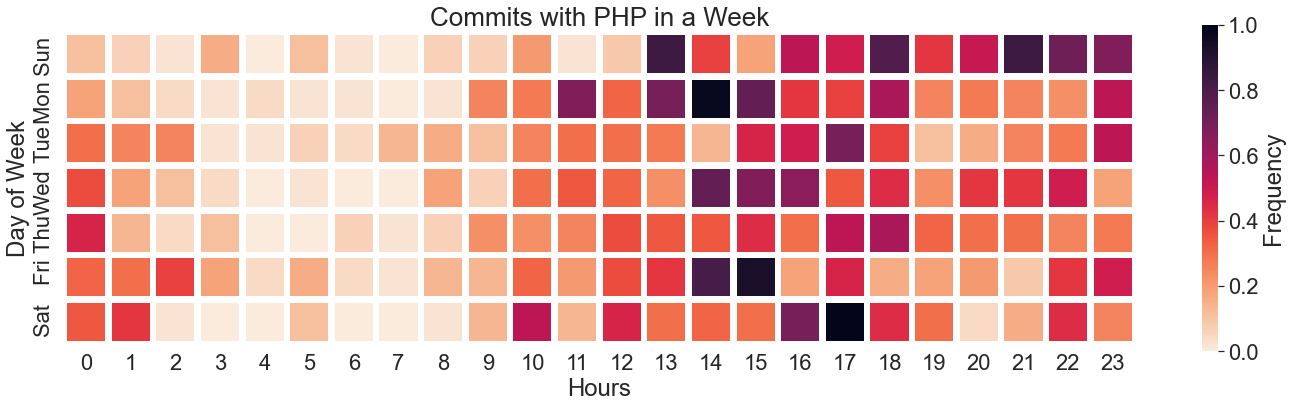

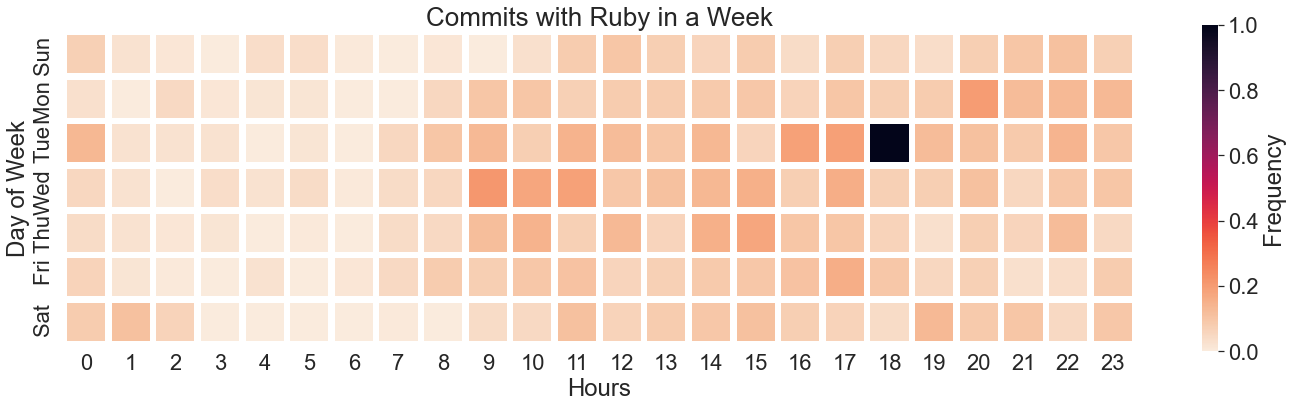

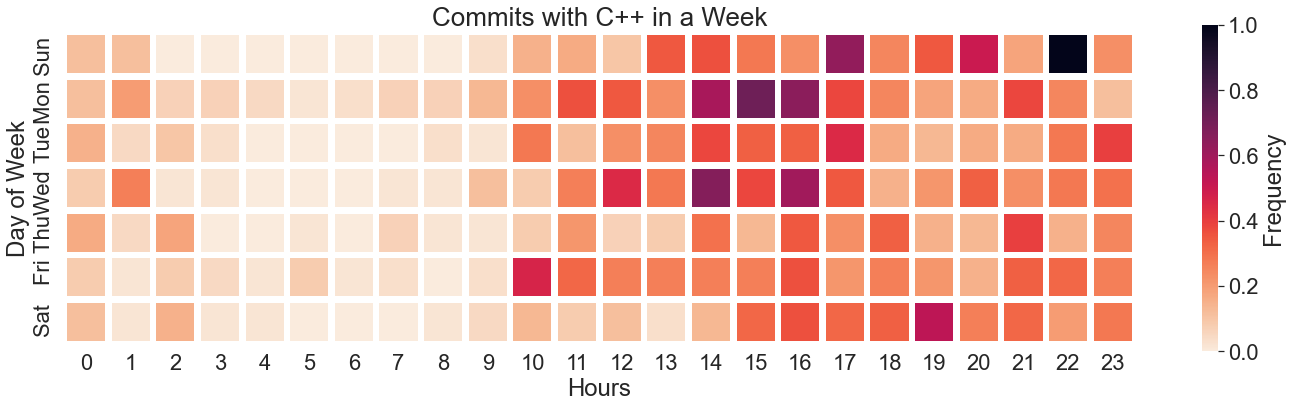

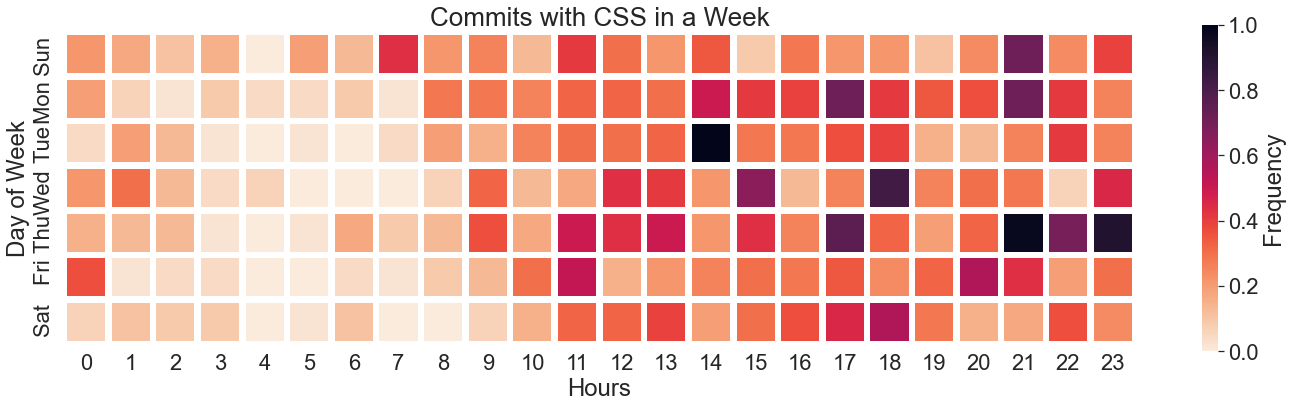

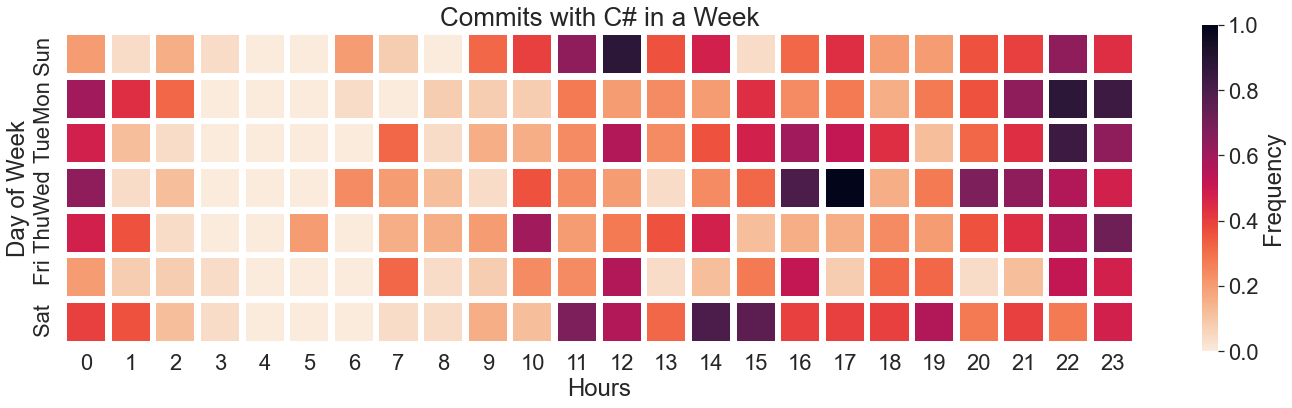

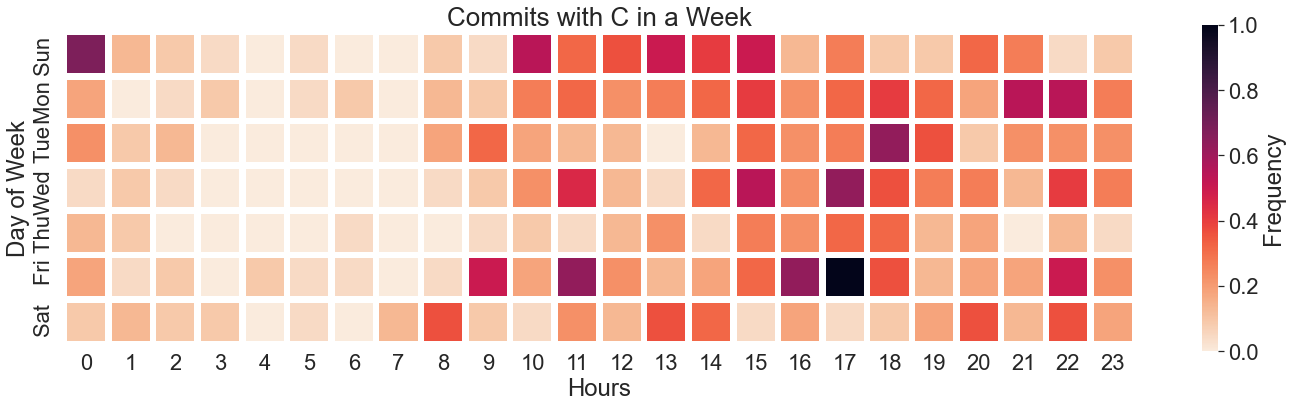

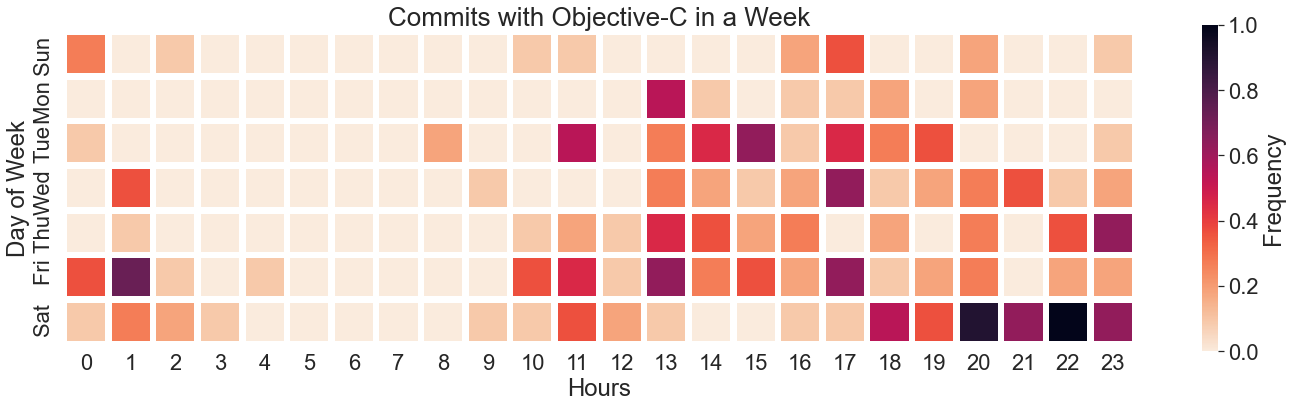

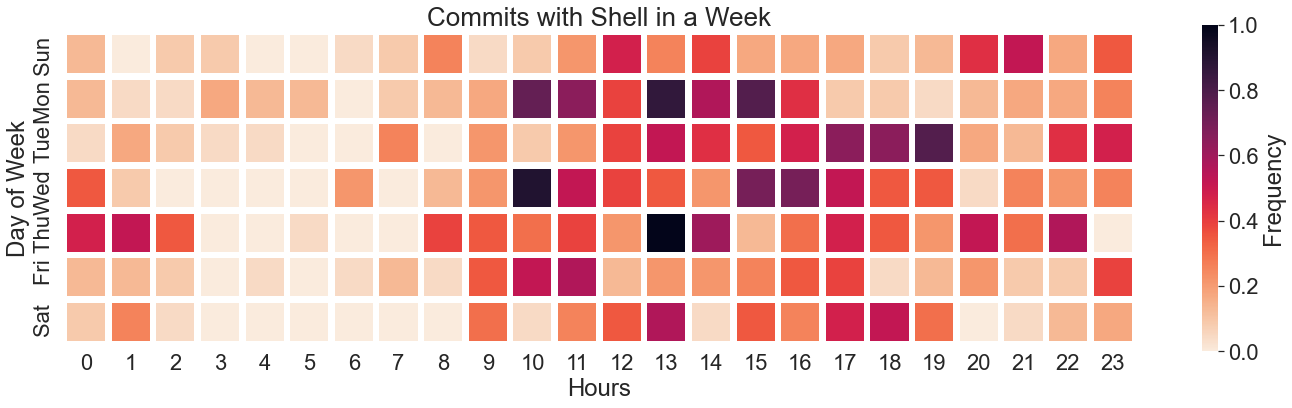

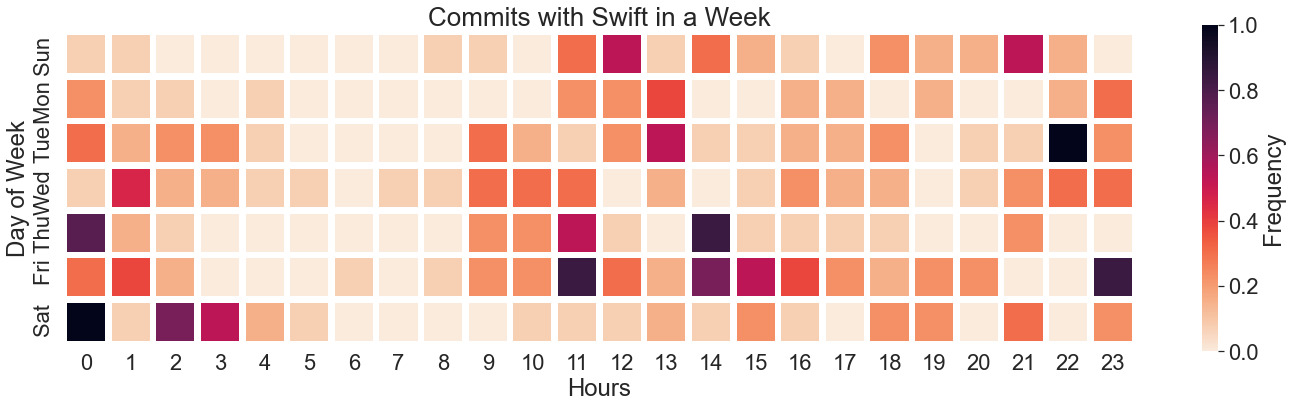

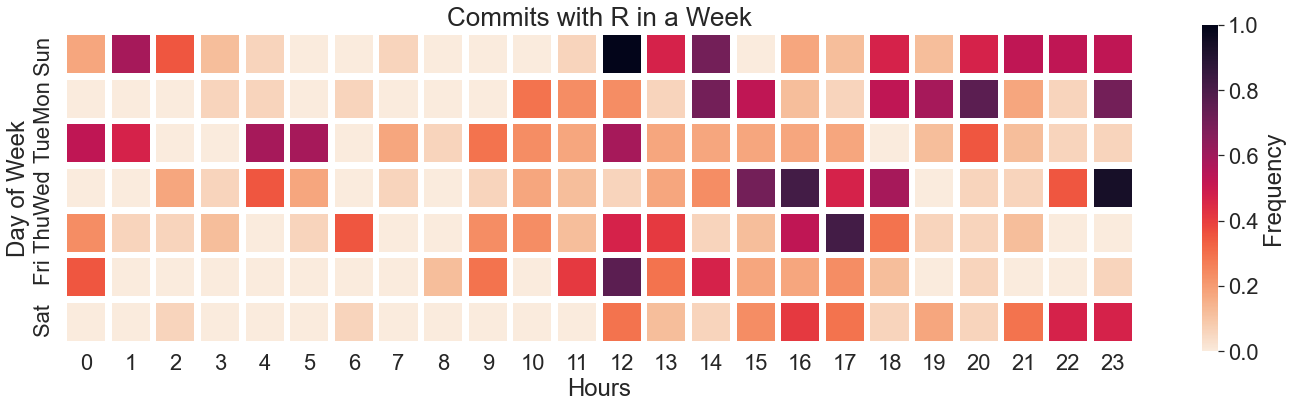

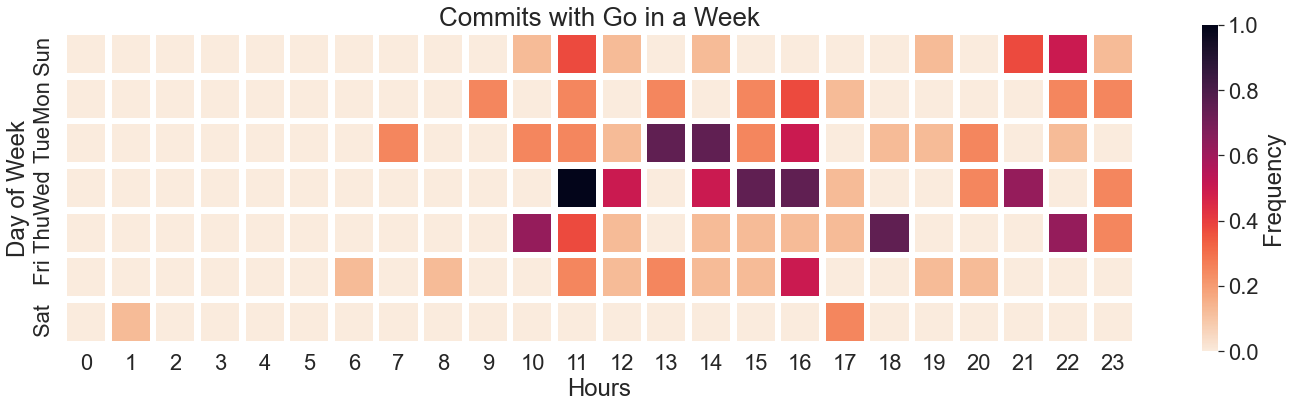

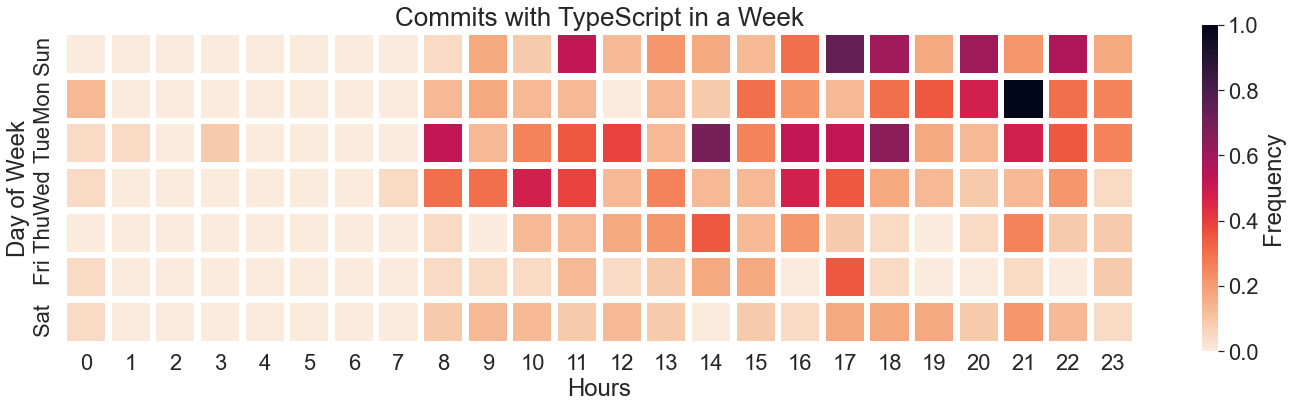

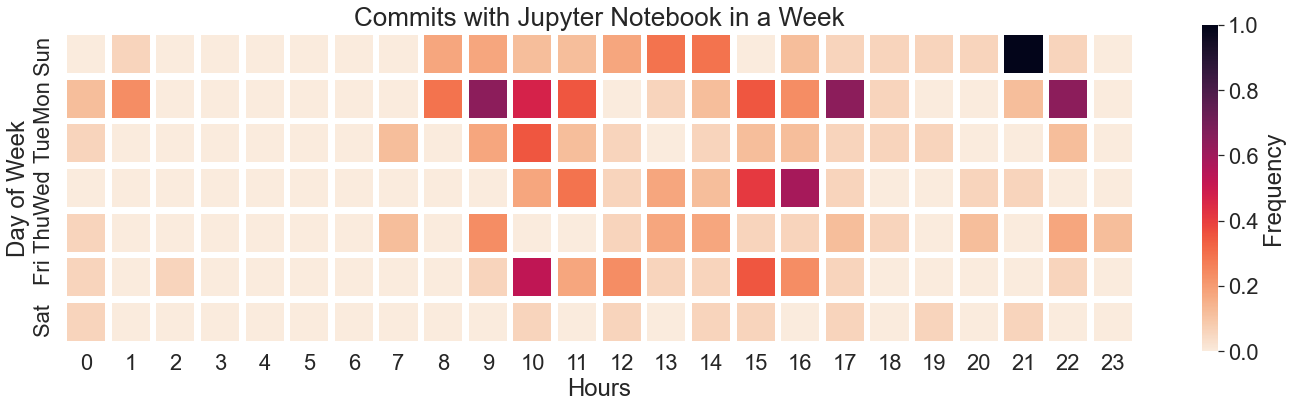

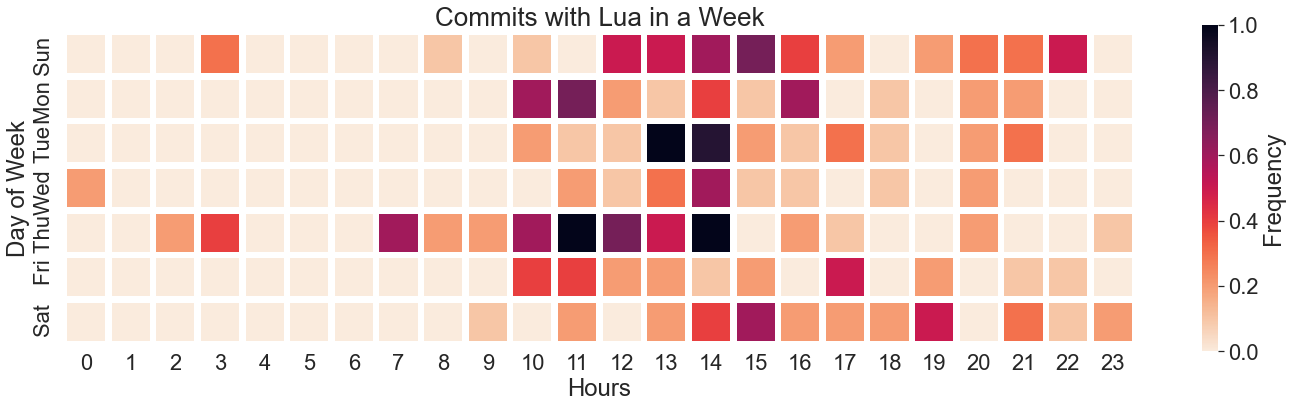

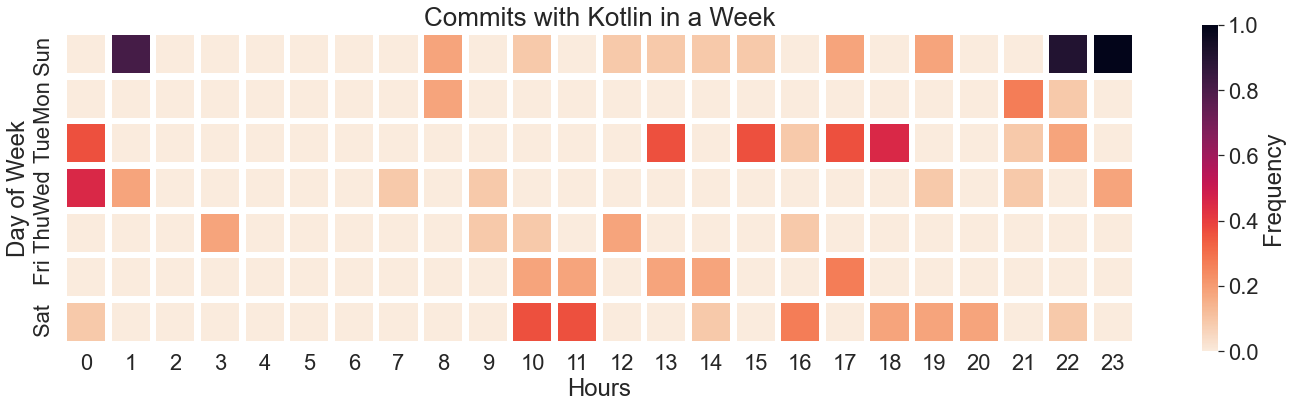

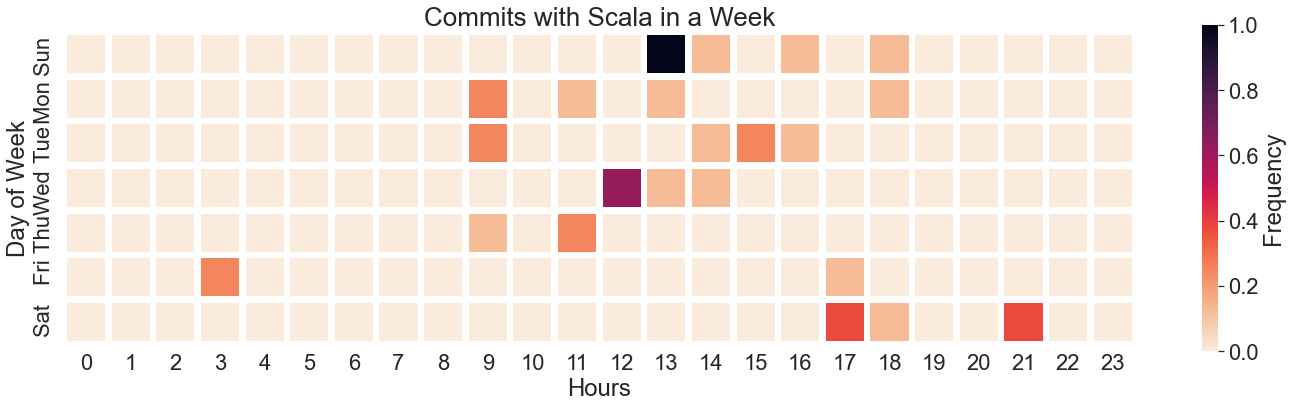

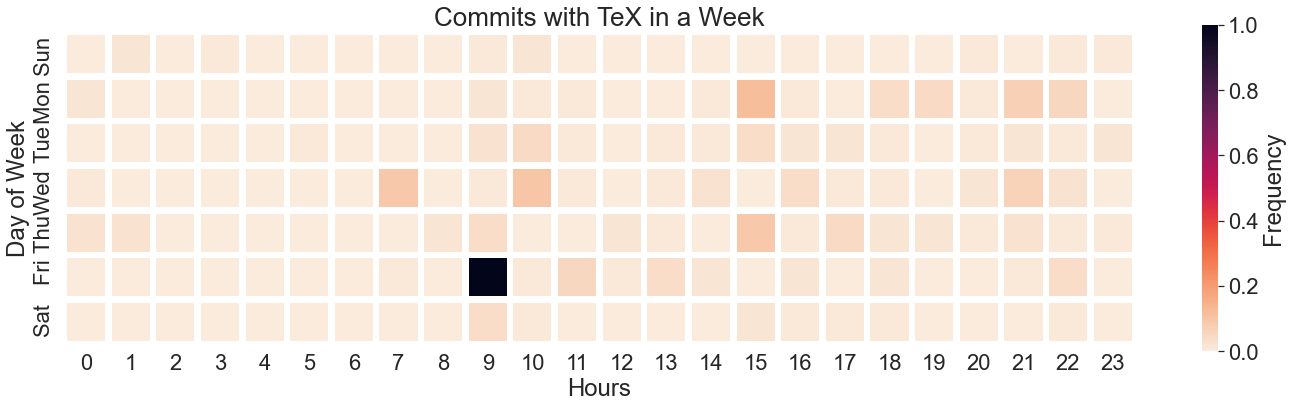

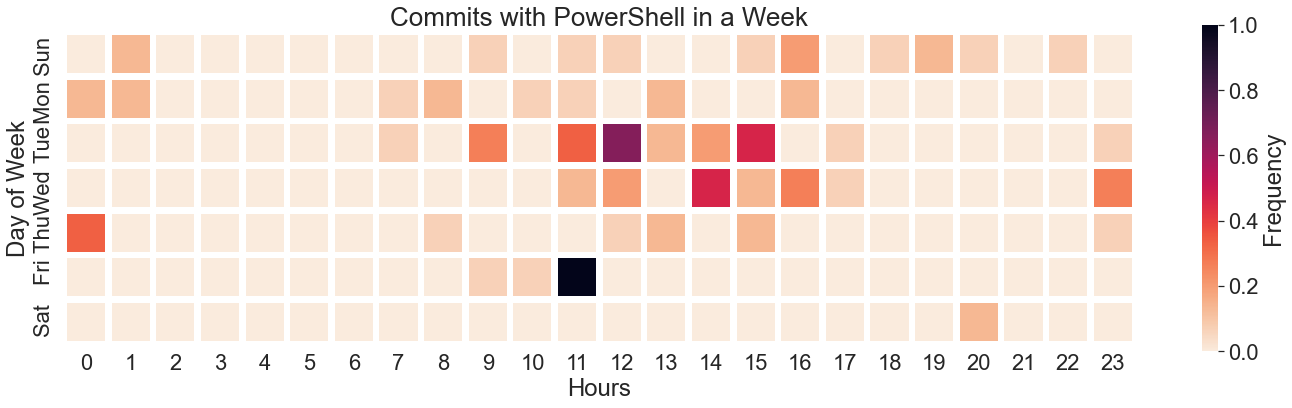

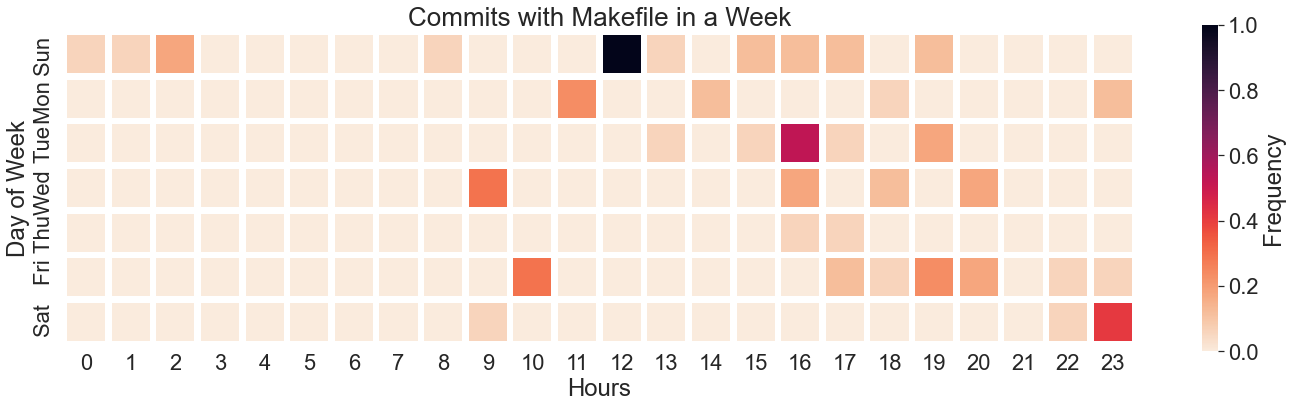

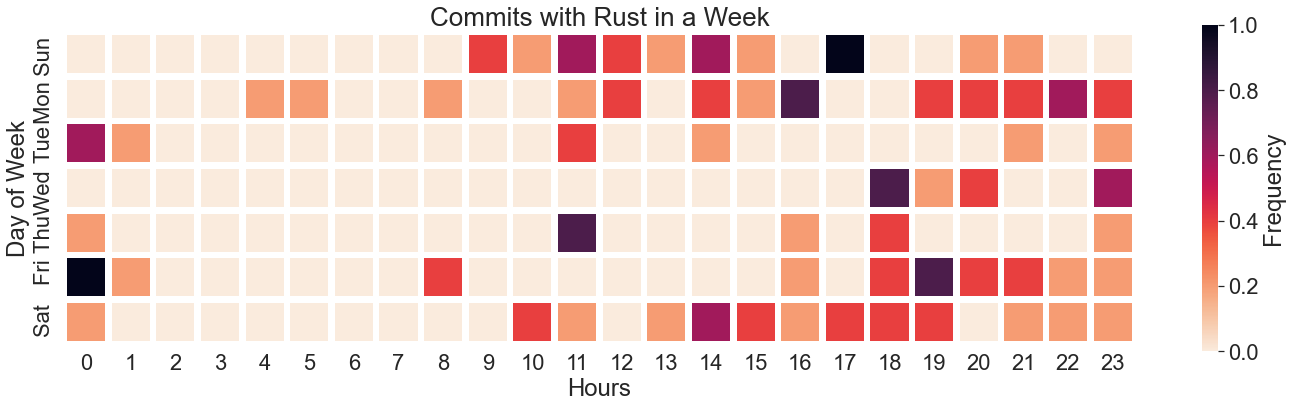

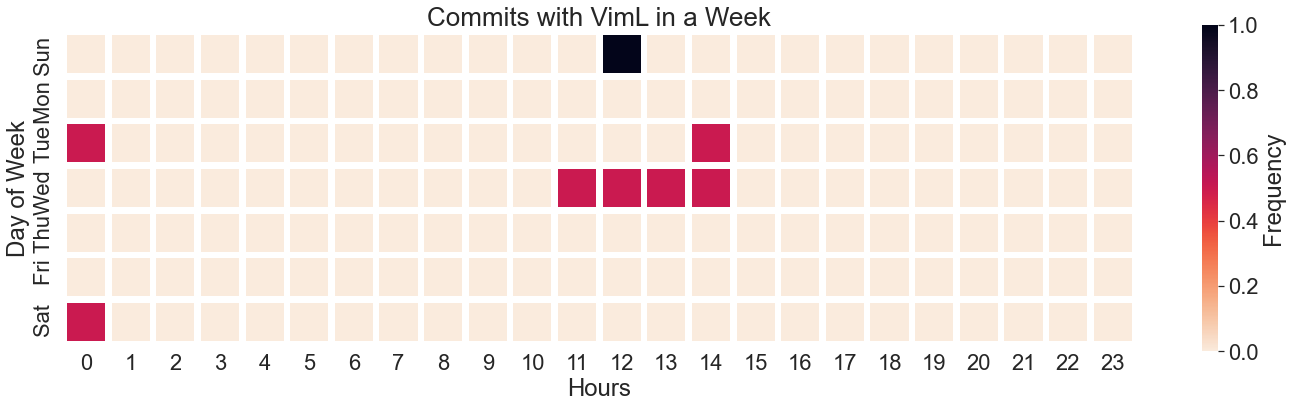

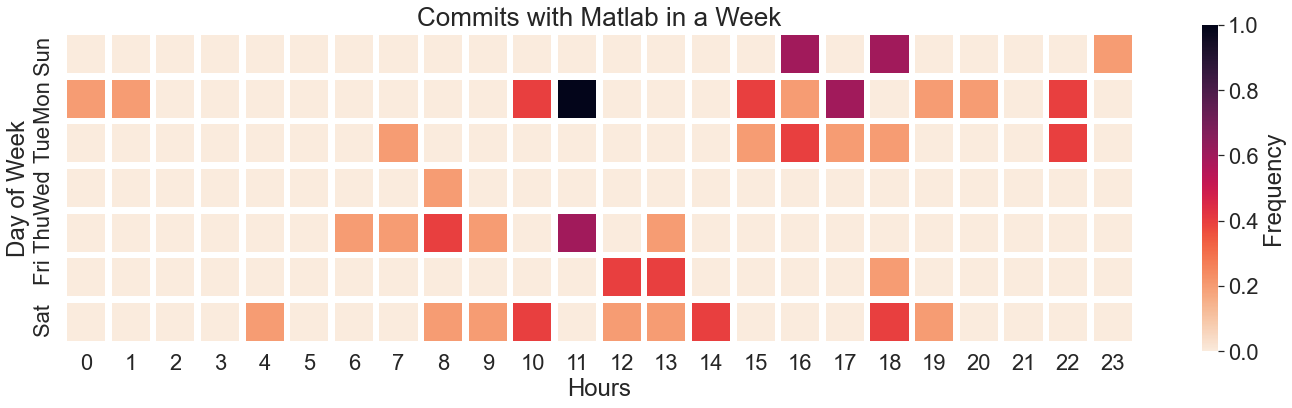

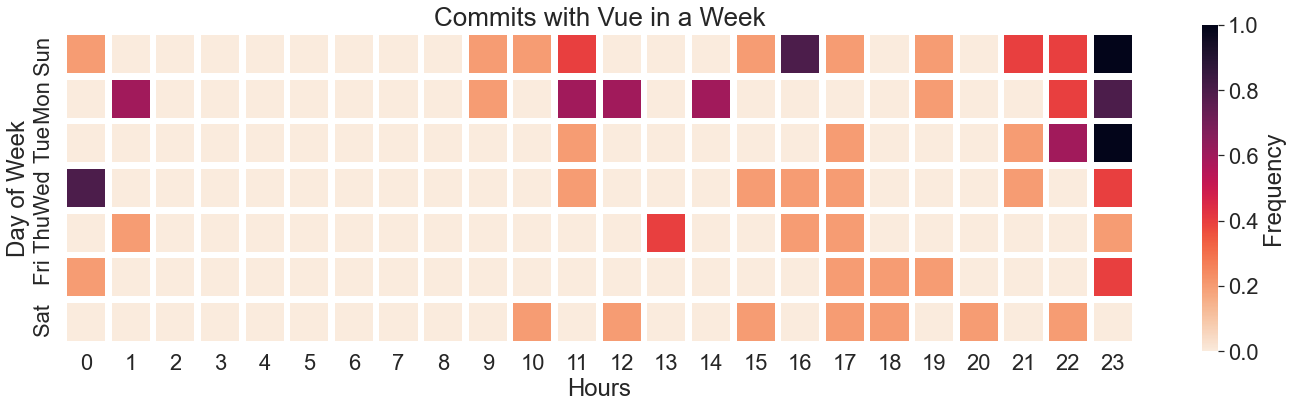

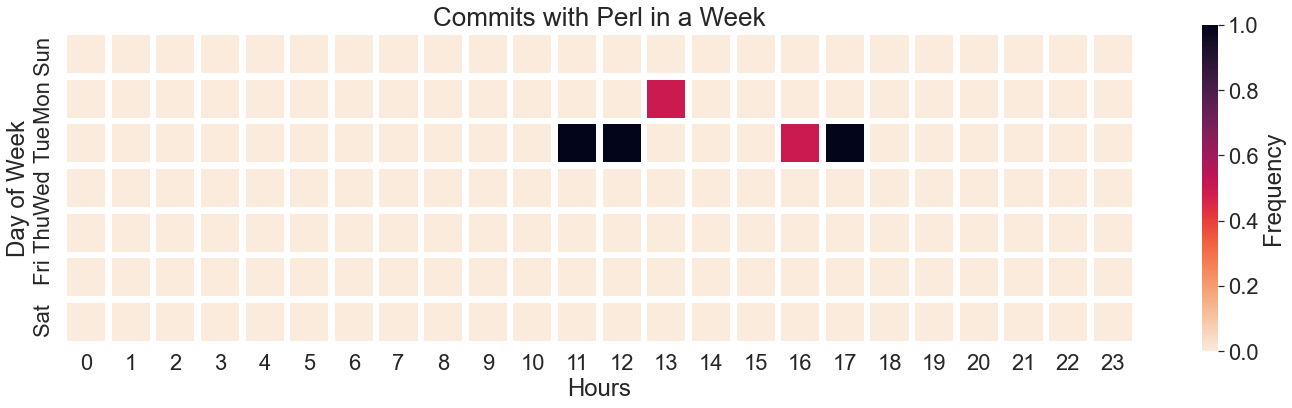

In [11]:
show_lang_heatmap('Rust')
show_lang_heatmap('Haskell')
for (lang, _) in all_langs[1:30]:
    show_lang_heatmap(lang)